
Привет, меня зовут Люман Аблаев. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на красные комментарии ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:


<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

-------------------

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ...
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>







<font color='orange' style='font-size:24px; font-weight:bold'>Общее впечатление</font>
* Спасибо за очень качественную работу - видно, что приложено много усилий,
- Я оставил некоторые советы, надеюсь они будут полезными и интересными
- Есть некоторые недочеты, которые нужно поправить, но у тебя это не должно занять много времени)
- Жду обновленную работу


<font color='orange' style='font-size:24px; font-weight:bold'>Общее впечатление[2]</font>
* Спасибо за оперативность
- Приятно видеть фидбек 
- Недочеты исправлены - работа полностью корректна
- Рад был быть полезен. Удачи в дальнейшем обучении!



# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Нам предстоит провести исследование данных, проверить на наличие аномалий и избавиться от них. Далее, нам необходимо протестировать несколько моделей, одной из которой будет LightGBM, и как минимум одна- не бустинг. Надо будет сравнить результаты, время обучения и скорость предсказания и выбрать оптимальную.

Наш работа пройдет в 7 этапов:
- Загрузка данных
- Изучение данных
- Подготовка выборок
- Обучение разных моделей
- Анализ времени обучения, времени предсказания и качества моделей.
- Выбор лучшей модели
- Подведение итогов

Приступим к работе

 ## Произведем необходимые импорты

In [ ]:
!pip3 install category_encoders

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from tqdm import tqdm

import lightgbm as lgb

from catboost import CatBoostRegressor, cv, Pool


import category_encoders as ce


Расширим размеры ноутбука

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))


<div class="alert alert-block alert-success">
<b>Успех:</b> Импорты  на месте
</div>


## Подготовка данных

### Загрузим данные

In [ ]:
df = pd.read_csv('/datasets/autos.csv')
df.head()

Документация датасета

**Признаки**

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType`— тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак**

Price — цена (евро)

**Не информативными являются признаки:**
- `LastSeen` - дата последней активности пользователя
- `DateCreated` — дата создания анкеты
- `DateCrawled` — дата скачивания анкеты из базы


**Остается под вопросом:**
- `PostalCode` - почтовый индекс владельца анкеты (пользователя), так как возможно можно будет отследить изменение цены по регионам.
- `NumberOfPictures` - количество фотографий автомобиля, инетересно понаблюдать как это вообще влияет. Возмодно владельцы, которым  нечего скрывать, выкладывают больше фотографий.

### Изучим данные

Выведем общую  информацию о датасете

In [ ]:
df.info()

In [ ]:
df.describe()

**признак NumberOfPictures не имеет каких-либо значений отличных от 0, значит, он не несет никакого практического смысла для нас, можем его удалить**

В данных присутствую пропуски, в признаках отвечающих за дату нужно изменить тип данных на дату. Посмотрим на типы данных повнимательнее

In [ ]:
df.dtypes

Скопируем изначальный датасет в запасную переменную

In [ ]:
df_init = df.copy()

In [ ]:
df_1 = df.copy()

In [ ]:
%%time

df_1=df_1.drop('LastSeen', axis=1)

In [ ]:
%%time

del df['LastSeen']


будем использовать конструкцию drop, так как она привычнее и можно удалить сразу несколько столбцов

In [ ]:
df.columns

In [ ]:
df = df.drop(['DateCrawled', 'DateCreated','NumberOfPictures'],axis=1)


<div class="alert alert-block alert-success">
<b>Успех:</b> Удалить неинформативные признаки - верное решение.
</div>

In [ ]:
df.columns

Выделим int и object признаки

In [ ]:
df.dtypes

In [ ]:
numeric_feats = ['Price', 'RegistrationYear','Power','Kilometer','RegistrationMonth','PostalCode']
obj_feats = ['VehicleType','Gearbox','Model','FuelType','Brand','Repaired']

#### Разберемся с пропусками

In [ ]:
df.isna().sum()

In [ ]:
display(df['VehicleType'].unique())
df['VehicleType'].value_counts()

In [ ]:
df.groupby(by=['Brand','PostalCode']).mean()

**избавимся от пропусков**


In [ ]:
df_test = df.copy()

Посмотрим какой у нас баланс в каждом признаке

In [ ]:
filled_objects = ['VehicleType','Gearbox','Model','FuelType','Repaired'] # объекты которые подлежат заполнению

In [ ]:
for feat in filled_objects:
    df[feat].value_counts().plot(kind='bar',figsize=(10,10), title=feat);
    plt.show()
# df_test[['VehicleType','Gearbox','Model','FuelType','Repaired']].value_counts().plot(kind='bar',figsize=(10,10));

In [ ]:
df[['VehicleType','Gearbox','Model','FuelType','Repaired']] = (df
         .groupby(['Brand'])[['VehicleType','Gearbox','Model','FuelType','Repaired']]  # группируем авто по маркам
         .apply(lambda x: x.sort_values(by='VehicleType').fillna(method="bfill").fillna(method="ffill"))  # производим замены внутри групп марок
         .droplevel(0)   # избавляемся от мультииндекса
         .sort_index(ascending=True))[['VehicleType','Gearbox','Model','FuelType','Repaired']] # сортируем строки по индексу

In [ ]:
df.isna().sum()

In [ ]:
df = df.dropna(subset=['Model'])
df.isna().sum()

<div class="alert alert-block alert-success">
<b>Успех:</b> Пропуски обработаны хорошим образом
</div>


<div class="alert alert-block alert-info">
<b>Совет:</b> У fuel_type есть категории, которые означают одно и тоже - их можно объединить, либо подумать может они действительно означают, что-то разное.
</div>


<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> 
   Дествительно, изучим две самых популярные категории. Petrol и gasoline это два английских слова для одного русского - бензин.
    
   НО, считаю, что не стоит их объединять в одну группу, потому что это версии британская и американская, значит машины тоже скорее всего принадлежат к разным странам производства, значит эти категории могут по-разному влиять на цены!
    
</div>

<div class="alert alert-block alert-success">
<b>Успех[2]:</b> Звучит логично - версию принял.
</div>


In [ ]:
%%time
filled_objects = ['VehicleType','Gearbox','FuelType','Repaired'] # объекты которые подлежат заполнению

plt.figure(figsize=(10,10))
for feat in filled_objects:
    df_dinamic = pd.concat([df_test[feat].value_counts(),df[feat].value_counts()],names=['1','2'],axis=1)
    df_dinamic.columns=[str(feat)+' before change', str(feat)+' after change']
    df_dinamic.plot(kind='bar', );
    plt.show();

отлично, заменили пропуски, примерно сохранив баланс классов.

#### Проверим датасет на аномалии

In [ ]:
for feat in numeric_feats: 
    df[feat].plot(kind='box',grid=True, title='box plot for '+str(feat))
    plt.show()

In [ ]:
xl = [(0,20100), (1900,2100),(0,300),(0, 160000), (0,12),(0,100001)]
i = 0
for feat in numeric_feats: 
    df[feat].plot(kind='hist',grid=True, title='hist plot for '+str(feat), bins=100,xlim=xl[i])
    plt.show()
    i+=1
    

#### Исправляем аномалии

**Цена**

Цены оставим почти без изменений, но нужно только избавиться от совсем маленьких стоимостей.


In [ ]:
df.loc[(df['Price']<100)&(df['Price']>=0)].shape

Избавимся от этих данных, потому что их не так много ,чтобы это как-то серьезно сказалось на обучении.

In [ ]:
df = df.loc[df['Price']>100]
df.shape


<div class="alert alert-block alert-success">
<b>Успех:</b>  Самое интересное, что на нескольких сайтов по продажам подержанных автомобилей в Германии (страну можно определить по почтовым индексам, большинство из них из Германии) показало, что цены начинаются действительно с 0 и 1 евро, но это единичные объявления и не понятно, то ли это ошибка при заполнении формы, то ли машины на металлолом. Но я  все-таки склоняюсь к тому, чтобы избавиться от таких данных
</div>


**Год регистрации**

Проанализировав сайт auto.ru стало заметно, что до 1960 года, можно найти только очень редкие автомобили, и их всего 120 штук, поэтому посмотрим сколько всего позиций выходит за пределы наших рамок

In [ ]:
df.loc[(df['RegistrationYear']<=1960)|(df['RegistrationYear']>=2023)].shape

In [ ]:
df.shape

Уверен, что мы смело можем отбросим эти неммногочисленные аномалии

In [ ]:
df = df.loc[(df['RegistrationYear']>1960)&(df['RegistrationYear']<=2023)]
df.shape


<div class="alert alert-block alert-info">
<b>Совет:</b> Советую посмотреть на дату выгрузки анкет - там тоже можно увидеть полезную информацию по поводу границ года регистраци.
</div>




In [ ]:
df_init.columns

In [ ]:
df_init.loc[(df_init['RegistrationYear']<1960)|(df_init['RegistrationYear']>2023),['DateCrawled','RegistrationYear']].head(20)

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> 
    
   Не заметил никакой закономерности):
</div>

<div class="alert alert-block alert-success">
<b>Ответ[2]:</b> Год регистрации авто не может быть больше даты скачивания анкеты из базы
</div>


**Количество сил**

Проанализировав сайт auto.ru, могу сказать, что зачастую автомобили имеют количество сил менее 350, но бывают исключения, бы на них постараемся закрыть глаза, потом учто это уже очень редко попадающиеся автомобили.

Проверим сколько таких автомобилей есть в наших данных.

In [ ]:
df.loc[df['Power']>350].shape

Очень маленькое количество вылезает за эти пределы, поэтому безболезненно отбросим эти строки

In [ ]:
df['Power'].plot(kind='box', ylim=(0,100))

In [ ]:
df.loc[df['Power']<1].shape

In [ ]:
df.loc[df['Power']<50].shape

Реалистичная мощность автомобилей находится в пределах 50-350 л.с.

In [ ]:
df = df.loc[(df['Power']<=350)&(df['Power']>=50)]
df.shape


<div class="alert alert-block alert-info">
<b>Совет:</b> А около-нулевые мощности?




<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> 
    
   Точно! Исправил это!
</div>

<div class="alert alert-block alert-success">
<b>Успех[2]:</b> Есть
</div>


**Пробег**

Пробег трогать не будет, потому что значения лежат в пределах нормы, поэтому оставим все как есть

**Месяц регистрации**

Месяц регистрации, на столбчатом графике видим, что значения месяца регистрации имеют значения от 0 до 12, очевидно, что нет 0го месяца. Поэтому заменим его на рандомное значение в пределах от 1 до 12 включительно. Потому что не совсем понятно как именно влияет месяц регистрации на стоимость. Но я слышал убеждение, что есть действительно такая закономерность, постараемся ее тоже проверить.

In [ ]:
state = np.random.RandomState(12345)

In [ ]:
df.loc[df['RegistrationMonth']==0, 'RegistrationMonth'] = np.random.randint(1,12)


In [ ]:
df['RegistrationMonth'].plot(kind='hist',grid=True, title='hist plot for RegistrationMonth', bins=100)
plt.show()

**Почтовый индекс**

С почтовым индексом все впорядке

### Проверим на явные дубликаты

In [ ]:
df.duplicated().sum()

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.duplicated().sum()

In [ ]:
df.shape

### Попробуем найти неявные дубликаты

In [ ]:
df.columns

In [ ]:
df['VehicleType'].unique()

In [ ]:
df['Gearbox'].unique()

In [ ]:
df['Model'].sort_values().unique()

In [ ]:
df['Brand'].sort_values().unique()

Неявных дубликатов обнаружено не было!

### Итоги подготовки данных

Провели все необходимые проверки данных.

Посмотрели на количество пропусков. Устранили пропуски за счет замены их на значения, которые получили при разделение на группы по брендам, так как в брендах нет пропусков, не появилось никаких аномалий.

Проверили данные на аномалии, избавились от выбросов, удалив данные, так как их количество было мало.

Проверили на явные и неявные дубликаты, удалили явные дубликаты, неявных дубликатов в данных нет.


<div class="alert alert-block alert-success">
<b>Успех:</b> В целом хорошая, детальная предобработка - идем дальше
</div>

<div class="alert alert-block alert-info">
<b>Совет:</b> 

 Советую обратить внимание на библиотеки sweetviz и pandas_profiling помогут в проведении более тщательного EDA анализа. Исследовательский анализ можно делать и с помощью ручного вызова функций дефолтных библиотек. Данные библиотеки хороши для максимизации комфорта презентации результатов анализа бизнес-пользователям. 
    
Очень просты в использоовании, на вход кладется датафрейм: pandas_profiling.ProfileReport(df) 
</div>


In [ ]:
!pip3 install pandas_profiling[notebook]

In [ ]:
from pandas_profiling import ProfileReport


profile = ProfileReport(df, title="Pandas Profiling Report")

# запускаем показ профиля
profile

## Обучение моделей

Наша задача заключается в тестировании нескольких моделей.Этими моделями будут:
- [x] LinearRegression
- [x] RandomForestRegressor
- [x] LightGBM
- [x] CatBoost




### Разделим данные на выборки

Приходится делить выборки в отношении 6:4, потому что иначе при большей обучающей выборке умирает ядро):

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения:
    
   Вернул валидационную выборку, так как все-таки использовать только кросс-валидацию не лучшая идея, так как нам надо отдельно узнавать врем яна обучение и на валидацию(предсказание)
</div>


In [ ]:
features = df.drop('Price', axis=1)
target = df['Price']

features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test, target_valid_test, test_size=0.5, random_state=12345)



print('Соотношение выборок: обучающая', features_train.shape[0],': валидационная',features_valid.shape[0],': тестовая',features_test.shape[0])

#### Проведем прямое кодирование, бинарное кодирование для категориальных признаков.

In [ ]:
features_train.dtypes

In [ ]:
encoder_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

obj_feats = features_train.select_dtypes(include='object').columns.to_list()

encoder_ohe.fit(features_train[obj_feats])

# print(encoder_ohe.get_feature_names())
# features_train[] = encoder_ohe.transform(features_train[obj_feats])



In [ ]:
features_train_ohed = features_train.copy()

features_train_ohed[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_train_ohed[obj_feats])

features_train_ohed = features_train_ohed.drop(obj_feats, axis=1)

In [ ]:
features_test_ohed = features_test.copy()
features_test_ohed[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_test_ohed[obj_feats])

features_test_ohed = features_test_ohed.drop(obj_feats, axis=1)

In [ ]:
features_valid_ohed = features_valid.copy()
features_valid_ohed[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_valid_ohed[obj_feats])

features_valid_ohed = features_valid_ohed.drop(obj_feats, axis=1)

Провели прямое кодирование(One Hot Encoding) теперь приступим к обучению


<div class="alert alert-block alert-danger">

<b>Ошибка:</b>  OHE правильный выбор для линейных моделей. Но для всех других моделей выбор плохой (из-за фактора модели, который порождает много факторов), для заказчика важно время обучения и скорость предсказания, а данные модели могут работать и с другими методами кодировками значительно быстреее, не теряя при этом в качестве.

Я тебе могу предложить, что можно сделать:
    
- Сделать 1 набор данных: 
    - Закодировать для всех моделей методом TargetEncoder, BinaryEncoder - вполне универсальные варианты
    - Закодировать все признаки методом OHE, а модель машины методом OE
    - Убрать использование линейных моделей (так как их рассмотрение не обязательно) и использовать единственный метод кодировки OE.
- Сделать 2 набора данных
    - Закодировать для линейных моделей методом OHE, для остальных OE (или внутренний метод кодирования данных)
    

</div>




<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения:
    
   Заменил прямое кодирование на бинарное. Применил это кодирование для данных, будем сначала обучать все модели ~~кроме линейной, ее мы уберем~~ РЕшил оставить, так как весь код есть и менять что-то необходимости нет
</div>



<div class="alert alert-block alert-success">
    
<b>Успех[2]:</b> 👍
</div>


In [ ]:
features_train_encoded = ce.BinaryEncoder().fit_transform(features_train)
features_train_encoded.head()

In [ ]:
binenc = ce.BinaryEncoder().fit(features_train)
features_test_encoded = binenc.transform(features_test)

In [ ]:
features_valid_encoded = binenc.transform(features_valid)

In [ ]:
features_test_encoded.head()

### Линейная регрессия

In [ ]:
numeric = numeric_feats[1:]
numeric

#### Масштабируем данные для линейной регрессии

In [ ]:
scaler = StandardScaler()

scaler.fit(features_train[numeric])

features_train_scaled, features_test_scaled = features_train.copy(), features_test.copy()


features_train_scaled_ohed = features_train_ohed.copy()
# features_valid_scaled_ohed = features_valid_ohed.copy()
features_test_scaled_ohed = features_test_ohed.copy()

features_train_scaled_ohed[numeric] = scaler.transform(features_train[numeric])
# features_valid_scaled_ohed[numeric] = scaler.transform(features_valid[numeric])
features_test_scaled_ohed[numeric]  = scaler.transform(features_test[numeric])

# scaler= StandardScaler()
# features_valid[numeric] = scaler.transform(features_valid[numeric])

In [ ]:
features_train_scaled_ohed.columns

<div class="alert alert-block alert-success">
<b>Успех:</b> Препроцессоры применены корректно

####  Приступим к обучению регрессии

In [ ]:
%%time
model_l = LinearRegression()


# (lasso, X, y, cv=3) model, feats, targ, cv
predictions_cv_lin = model_l.fit(features_train_ohed, target_train)

In [ ]:
%%time
predictions_lin_valid = model_l.predict(features_valid_ohed)

In [ ]:
rmse_cv_lin = mean_squared_error(target_valid, predictions_lin_valid)**0.5
print('RMSE Линейной регресси равно:', rmse_cv_lin)

Очень плохой результат показала линейная регрессия, перейдем к случайному лесу

In [ ]:
time_fit_lin = 22.7 # секунд
time_pred_lin = 0.077
rmse_valid_lin = 2614.89

### Случайный лес

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Поменял выборку с прямым кодированием на выборку с бинарным кодированием
</div>

In [ ]:
%%time
best_depth = 0


best_est = 0

rmse_f_best = 1e300

depthes = [None]+[i for i in range(2,7)]
for depth in tqdm(depthes):
    for est in range(10,121,25):
        
        model_f = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=12345)
        
        predictions_cv_forest = cross_val_predict(model_f, features_train_encoded, target_train)
        rmse = mean_squared_error(target_train, predictions_cv_forest)
        if rmse < rmse_f_best:
            best_depth = depth
            best_est = est 
            rmse_f_best = rmse
        

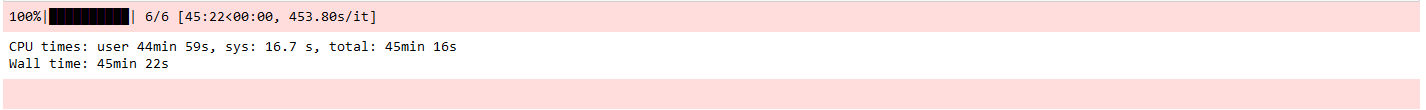

In [ ]:
print('Лучший rmse случайного леса равен:', rmse_f_best)
print('Лучшая глубина леса', best_depth, 'лучшее количество деревьев', best_est)

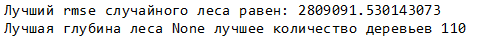

**Теперь обучим модель на обучающей выборке и протестируем на валидационной**

In [ ]:
model_f = RandomForestRegressor(n_estimators=110, max_depth=None, random_state=12345)

In [ ]:
%%time
model_f.fit(features_train_encoded, target_train)

In [ ]:
%%time
predictions_f = model_f.predict(features_valid_encoded)

Посмотрим на результаты

In [ ]:
rmse_forest = mean_squared_error(predictions_f,target_valid)**0.5
print('RMSE случайного леса равно:',rmse_forest)

In [ ]:
time_fit_f = 1*60+44
time_pred_f = 3
rmse_forest = 1647













































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































Результат уже гораздо лучше, чем у линейной регрессии, но все равно результат нас такой не устраивает.

### LightGBM

#### Этап с кросвалидацией можем пропустить, так как для задания он не нужен

In [ ]:
features_train.head()

In [ ]:
train_dataset = lgb.Dataset(features_train_ohed, target_train, feature_name=features_train_ohed.columns.to_list())
test_dataset = lgb.Dataset(features_test_ohed, target_test, feature_name=features_test_ohed.columns.to_list())

In [ ]:
%%time
# booster = lgb.train({"objective": "regression"},
#                     train_set=train_dataset, valid_sets=(test_dataset,),
#                     num_boost_round=10)

#  folds=sp,
cv_res = lgb.cv({"objective": "regression"}, train_dataset, 400, shuffle=False, seed = None,
            callbacks=[lgb.early_stopping(stopping_rounds=25, first_metric_only=True)],
            return_cvbooster=True)

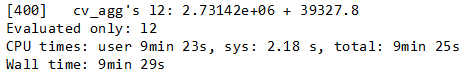

In [ ]:
# predictions_lgb = booster.predict(features_test_ohed)
# cv_res

In [ ]:
%%time
predictions_cv_lgb = cv_res['cvbooster'].predict(features_train_ohed)


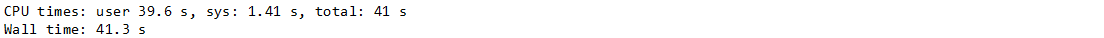

In [ ]:
len(predictions_cv_lgb[0])

In [ ]:
target_train

#### LightGBM обучение и предсказание

In [ ]:
train_dataset = lgb.Dataset(features_train_encoded, target_train, feature_name=features_train_encoded.columns.to_list())
valid_dataset = lgb.Dataset(features_valid_encoded, target_valid, feature_name=features_valid_encoded.columns.to_list())
test_dataset = lgb.Dataset(features_test_encoded, target_test, feature_name=features_test_encoded.columns.to_list())

In [ ]:
%%time
model_lgb = lgb.train({"objective": "regression"},
                    train_set=train_dataset, valid_sets=(valid_dataset,),
                    num_boost_round=400)

In [ ]:
%%time
predictions_valid_lgb = model_lgb.predict(features_valid_encoded)

In [ ]:
rmse_lgb = mean_squared_error(target_valid, predictions_valid_lgb)**0.5

print('rmse ', rmse_lgb)

In [ ]:
time_fit_lgb = 21.2
time_pred_lgb = 1.26
rmse_lgb = 1624

Отличный результат показал lightgbm, rmse равно 1624

### Catboost

#### Кросс-валидация
Будем считать, что кроссвалидация была проделана для ознакомления с библиоткеой

Используем катбуст регрессор, установим количество итераций 100, просто для тестирования.

In [ ]:
model_cat = CatBoostRegressor(iterations=100)

In [ ]:
cat_features = features_train.columns.to_list()

In [ ]:
# model_cat.cv(features_train, features)

In [ ]:
%%time
params = {
    'loss_function': 'RMSE',
    'iterations': 300,
    'random_seed': 12345,
    'learning_rate': 0.5
}

cv_data = cv(
    params=params,
    pool=Pool(features_train, label=target_train, cat_features=cat_features),
    fold_count=5, # Разбивка выборки на 5 кусочков
    shuffle=True, # Перемешаем наши данные
    partition_random_seed=12345,
    plot=True, # Никуда без визуализатора
    stratified=True, 
    verbose=False
)

#### CatBoost без кросс-валидации

In [ ]:
features_train.dtypes

In [ ]:
%%time
model_cat = CatBoostRegressor(iterations=400 , depth=5, learning_rate= 0.2)


cat_features = ['VehicleType','Gearbox','Model','FuelType','Brand','Repaired']
model_cat.fit(features_train, target_train, cat_features=cat_features, verbose=40, plot=True)

In [ ]:
%%time
predictions_cat = model_cat.predict(features_valid)

In [ ]:
rmse_cat = mean_squared_error(target_valid, predictions_cat)**0.5
print('Значение RMSE для модели catboost равно', rmse_cat)

Отлично, мы получили метрику rmse равную 1670.

In [ ]:

time_fit_cat = 45.6
time_pred_cat = 0.181
rmse_cat = 1636

### Итоги обучения

Провели обучение 4 моделей обучения, два бустинга : lightgbm и catboost и два не бустинга: линейная регрессия и случайный лес. В следующем пункте сравним модели по времени обучения, времени предсказания и качеству предсказания

## Анализ моделей

Перейдем к анализу моделей, мы в нашем исследовании использовали 4 модели, LightGBM, CatBoost, LinearRegression, RandomForestRegressor. Перейдем к сравнению по времени обучения, по времени предсказания, по качетсву предсказания.

In [ ]:
print('Линейная регрессия')
print('Время обучения',time_fit_lin,'секунд. Время предсказания',time_pred_lin,'секунд. Качество модели', rmse_valid_lin)
print()
print('Случайный лес')
print('Время обучения',time_fit_f ,'секунды. Время предсказания',time_pred_f,'секунд. Качество модели', rmse_forest)
print()
print('LightGBM')
print('Время обучения',time_fit_lgb ,'секунд. Время предсказания',time_pred_lgb,'секунд. Качество модели', rmse_lgb)
print()
print('CatBoost')
print('Время обучения',time_fit_cat ,'секунд. Время предсказания',time_pred_cat,'секунд. Качество модели', rmse_cat)



<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Ты немного не правильно понял метрики времени: Нам нужно и время обучения и время предсказания  вычислить  и проанализировать отдельно друг от друга
    
- время обучения это  чистый `.fit()` модели 
    
- время предсказания это только `.predict()` без обучения

</div>

<div class="alert alert-block alert-warning">
<b>Вопрос студента:</b> То есть правильно понимаю, что необходимости в кроссвалидации в данном задании нет?
   
</div>


<div class="alert alert-block alert-success">
    
<b>Успех[2]:</b> Желательно подбирать гиперпараметры для моделей, чтобы сделать их более правильными для текущих данных, но это не ключевое в этом спринте. Поэтому все в порядке)
</div>


**Итоги сравнения**

CatBoost и LightGBM показали себя на достойном уровне, у них хорошее качетсво и достаточно быстрое обучение. Но у CatBoost есть одно огромное преимущество, для нескольких десятков тысяч строк признаков модель делает предсказания менее чем за 0.2 секунды. Я считаю, что в данном случае при остальных равных показателях, этот является самым важным.


<div class="alert alert-block alert-success">
<b>Успех:</b> А так отлично проделаны шаги
    
- Радует количество рассмотренных моделей.   
- Кросс-валидационные методы успешно использованы. 
</div>


<div class="alert alert-block alert-warning">
<b>Изменения:</b> Внес изменения в обучение и предсказание, сделал предсказания и обучение отдельными этапами, сравнил модели и лучшей оказалась СatBoost
   
</div>


<div class="alert alert-block alert-success">
    
<b>Успех[2]:</b> Выбор модели обсонован
</div>


### Итоговое обучение CatBoost и проверка на тестовой выборке

In [ ]:
model = CatBoostRegressor(iterations=400, random_seed=12345)

In [ ]:
%%time
model.fit(features_train, target_train, cat_features=features_train.columns.to_list(), plot=True,verbose=40)

In [ ]:
%%time
predictions_final = model.predict(features_test)

In [ ]:
rmse_final = mean_squared_error(target_test, predictions_final)**0.5
print('rmse финальной модели катбуст на тестовой выборке:', rmse_final)

Время обучения равно 105 секунд, а время предсказания примерно равно 0.4 секунды
А финальное качество равно 1620


<div class="alert alert-block alert-success">
<b>Успех:</b> На тестовой выборке получено хорошее качество!
</div>



### Узнаем важность каждого фактора

In [ ]:
importance = pd.DataFrame(np.array([model.get_feature_importance(),features_train.columns]).T, columns = ['importance', 'feature'])
importance = importance.sort_values(by='importance')
importance

In [ ]:
importance.plot(kind='barh', x='feature', title='Важность признаков в условных единицах')

Наша гипотеза о том, что почтовый индекс может влиять на цену не подтвердилась. Она не оказывает практически никакого влияния, точно также как и месяц регистрации. Самым важным признаком является год реистрации, это правда важно, потому что от этого признака зависит, наскоько машина старая.


<div class="alert alert-block alert-success">
    
<b>Успех[2]:</b> Отличная реализация
</div>


## Подведение итогов

Мы провели исследование данных, проверили на наличие аномалий и избавились от них. Далее, протестировали несколько моделей, а именно LinearRegression, RandomForestRegressor, lightGBM, CatBoostRegressor. Сравнили результаты, время обучения и скорость предсказания и выбрали оптимальную.

Во время работы было выолнено 7 следующих пунктов:

- Загрузка данных
- Изучение данных
- Подготовка выборок
- Обучение разных моделей
- Анализ времени обучения, времени предсказания и качества моделей.
- Выбор лучшей модели
- Подведение итогов

По итогам работы выбрали модель CatBoostRegressor, время обучения составило 90 секунд, предсказание заняло примерно 1 секунду для 125000 значений в тестовой выборке. Значение метрики rmse равно 1683, что означает, что задача успешно выполнена!



<div class="alert alert-block alert-info">
<b>Совет:</b> 

Также если говорить, что можно ещё улучшить в подобных проектах, то я бы выделил такие моменты:<br>
    
1) Для понимания, а какие в итоге факторы важны при моделировании, можно выводить их важность, использую feature_importances_, ну и график заодно. Это будет смотреться очнь здорово: результативная метрика и график важности факторов)))
    
2) У нас разный возраст машин. Есть гипотеза, что для разных возрастов - своё ценообразование. Поэтому, можно попробовать ввести фактор "тип возраста" (ретро, супер-ретро, старая, новая... надо подумать..)..<br>

3) У некоторых моделей семейства бустингов, есть внутренний метод кодировки данных, который хорошо было бы попробовать
</div>


## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей